In [17]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [18]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [37]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
feat_names = OrderedDict()
feat_names["ctcf_g4"] = "intersect-all-NT-CTCF-G4-centered"
feat_names["g4"] = "intersect-G4-NO-CTCF-centered"

## Read `feature_of_interest` that we want to look at using stackups ...
### we can also generate some random locations from hg19 using `generate_random_bed` ...

In [21]:
# bf is short for bioframe here ...
dfs = OrderedDict()
for k in feat_names:
    dfs[k] = bf.read_table(
        feat_names[k],
        names=["chrom","start","end"],
        usecols=(0,1,2),
        index_col=None
    )
    dfs[k] = dfs[k].sort_values(["chrom","start"])
    dfs[k] = dfs[k][dfs[k]["chrom"].isin(autosomal_chroms)]
    dfs[k] = dfs[k].reset_index(drop=True)

### explore spacing and footprints of the features being explored ...

simply plot distributions of the spacings between adjacent features and their sizes `end - start`  as well ...


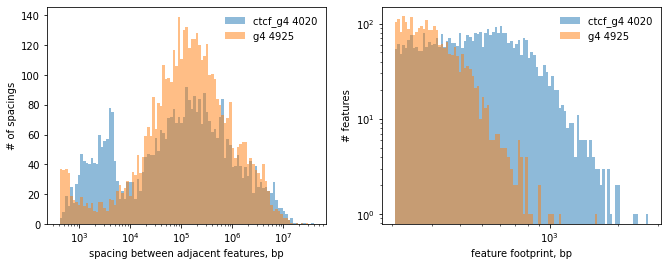

In [22]:
plot_spacing_footprint_distros(dfs)

### in our analyses (insulation/compartments) we wouldn't resolve features that are too close ...
#### let's see what clustering those adjacent ones could do for us
#### let's try to pick a good clustering "radius" first - should be  around ~1-10kb ...

it's actually merging that we're doing - i.e. we don't need to know cluster information - just need to collapse nearby intervals into larger ones

to see how varying clustering radius affects the results see the gist : blah ...

### after we explored how our features (intervals) are spaced and distributed
#### we can move on to the stackups - for different samples, different types of tracks, etc

In [39]:
#let's describe our samples that we want to have in Figure 1 ...
suppfig2D_samples = ["ctcf","noctcf","rad21_CTCF","rad21_noCTCF","ins_CTCF","ins_noCTCF","ev1_CTCF","ev1_noCTCF","G4a_r2","polII"]
titles = suppfig2D_samples

bw_fnames = OrderedDict()
binsizes = {}
flanks = {}
limss = {}
cmps = {}
norms = {}
for s in suppfig2D_samples:
    bw_fnames[s] = samples[s]["fname"]
    binsizes[s] = samples[s]["binsize"]
    flanks[s] = samples[s]["flank"]
    limss[s] = samples[s]["crange"]
    cmps[s] = samples[s]["cmap"]
    norms[s] = samples[s]["norm"]


### next is computation heavy step - stackups using bbi ...

In [24]:
# do all stackups with the parameters ...
stackup_dict = OrderedDict()
for k in dfs:
    stackups = {}
    print(f"going to stackup features {k}:({len(dfs[k])}) ...\n\n")
    for s in bw_fnames:
        print(f"stacking up {s} ...")
        %time stackups[s] = rstacks( bw_fnames[s], dfs[k], flank=flanks[s], binsize=binsizes[s], fill_missing=np.nan )
    stackup_dict[k] = stackups

going to stackup features ctcf_g4:(4020) ...


stacking up ctcf ...
CPU times: user 788 ms, sys: 68.5 ms, total: 857 ms
Wall time: 847 ms
stacking up noctcf ...
CPU times: user 702 ms, sys: 24.3 ms, total: 726 ms
Wall time: 726 ms
stacking up rad21_CTCF ...
CPU times: user 808 ms, sys: 56.2 ms, total: 864 ms
Wall time: 858 ms
stacking up rad21_noCTCF ...
CPU times: user 600 ms, sys: 56.3 ms, total: 657 ms
Wall time: 662 ms
stacking up ins_CTCF ...
CPU times: user 560 ms, sys: 31.8 ms, total: 592 ms
Wall time: 593 ms
stacking up ins_noCTCF ...
CPU times: user 503 ms, sys: 28.2 ms, total: 531 ms
Wall time: 530 ms
stacking up ev1_CTCF ...
CPU times: user 385 ms, sys: 16.3 ms, total: 401 ms
Wall time: 401 ms
stacking up ev1_noCTCF ...
CPU times: user 420 ms, sys: 20.2 ms, total: 440 ms
Wall time: 436 ms
stacking up G4a_r2 ...
CPU times: user 927 ms, sys: 44.3 ms, total: 972 ms
Wall time: 975 ms
stacking up polII ...
CPU times: user 523 ms, sys: 23.9 ms, total: 546 ms
Wall time: 542 ms
goin

In [26]:
# LET'S ADD GENES AS YET ANOTHER STACKUP TO THE DICT ...
annot_flank = 5_000
annot_binsize = 200
feat_name = "gene"
for k in dfs:
    print(f"stacking genes up for {k} ...")
    aaa = rstacks(
        "gene_plus.bb",
        dfs[k],
        flank=annot_flank,
        binsize=annot_binsize,
    )
    bbb = rstacks(
        "gene_minus.bb",
        dfs[k],
        flank=annot_flank,
        binsize=annot_binsize,
    )
    stackup_dict[k][feat_name] = aaa - bbb

    
#let's describe our samples that we want to have in Figure 1 ...
suppfig2D_samples.append(feat_name)
titles = suppfig2D_samples

s = feat_name
bw_fnames[s] = "blah"
binsizes[s] = annot_binsize
flanks[s] = annot_flank
limss[s] = (-1,1)
cmps[s] = "coolwarm"
norms[s] = None

# try to discriminate overlaping genes with the lack of genes  - white/gray  - fill missing nan ....

stacking genes up for ctcf_g4 ...
stacking genes up for g4 ...


### Normalize insulation stackups - subtract some value from each row in the stackup ...

In [27]:
# this is done INPLACE - be carefull !
# normalize all of the insulation stackups for all of the features lists
insulation_keys = [_k for _k in bw_fnames.keys() if _k.startswith("ins")]

for feature_key in stackup_dict:
    the_stackup = stackup_dict[feature_key]
    # define the size of the shoulder - flank size
    l, w = the_stackup["ins_CTCF"].shape
    norm_flank = int(w*0.25)

    normalize_insulation_stackups_INPLACE(
        the_stackup,
        insulation_keys,
        subtract = "shoulders",
        subtract_size = norm_flank,
    )

In [40]:
# insulation
for s in insulation_keys:
    limss[s] = (-.25,0.02)
    cmps[s] = cmapYlGnBu_r

### sort by EV1 ...

In [29]:
# NOW REORDER A STACKUPS FOR EACH FEATURE ACCORDING TO SOMETHING ....
reordered_jdxs = OrderedDict()
for feature_key in stackup_dict:
    the_stackups = stackup_dict[feature_key]
    # for a given set of stackups for a given list of features ...
    length,width = the_stackups['ev1_CTCF'].shape
    center_bin = int(width/2)
    the_stackups['ev1_drop'] =  np.nanmean(the_stackups['ev1_CTCF'][:,1:center_bin],axis=1) - \
                                np.nanmean(the_stackups['ev1_CTCF'][:,-center_bin:-1],axis=1)
    _, _jjj = recursive_data_ordering(
        ks = [('ev1_drop', "sort", 1, False)],
        idxs = np.arange( length ),
        data_dict = the_stackups,
        verbose=True
    )
    reordered_jdxs[feature_key] = _jjj


sorting 4020 elements of ev1_drop into 1 groups ...
sorting 4925 elements of ev1_drop into 1 groups ...


### actual figure for SUpplement

#### Now sort on compartment "flip" to see A->B and B->A flips as they are ...

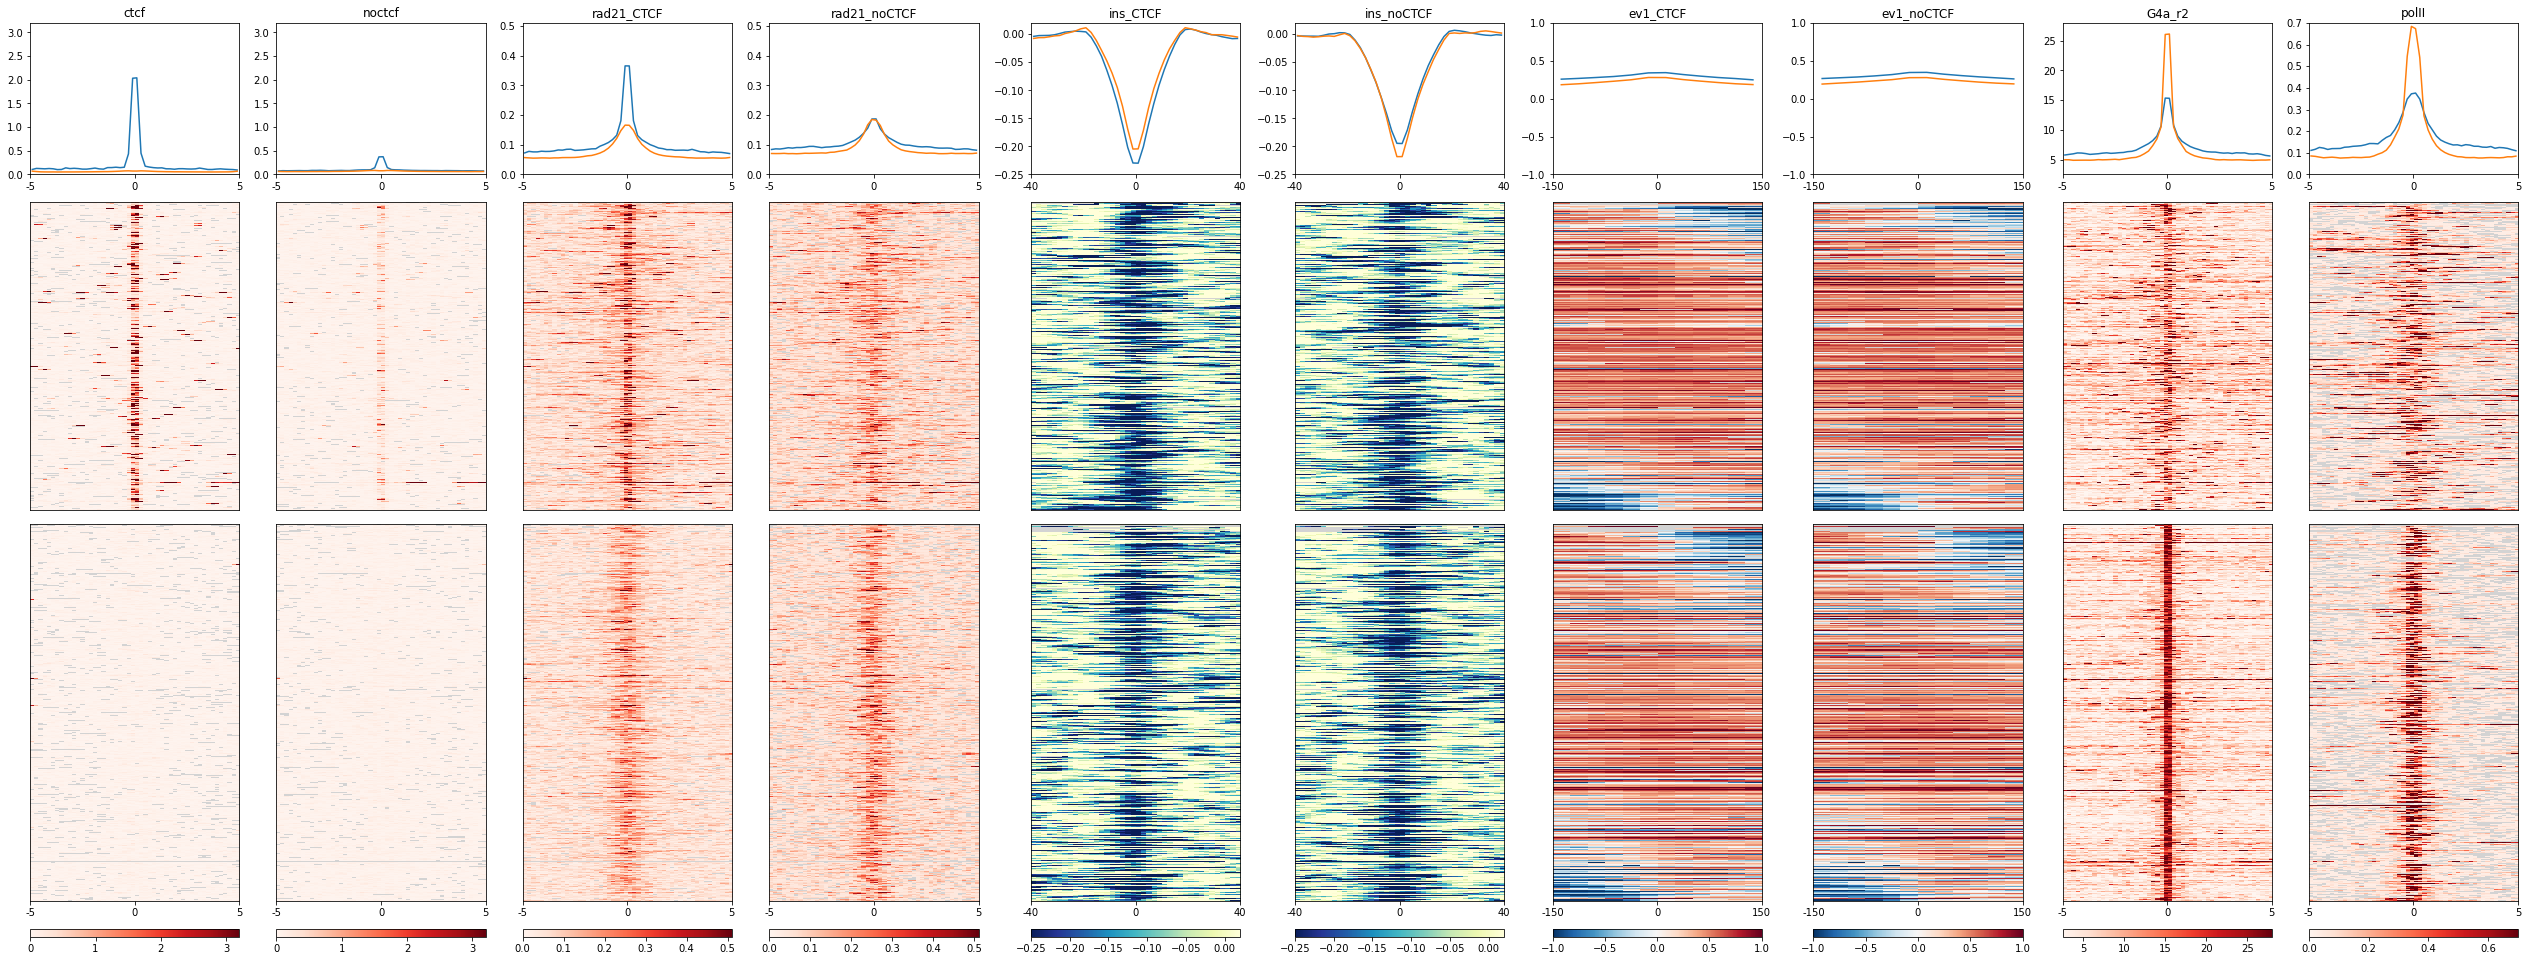

In [42]:
hmss = OrderedDict()

for feature_key in ['ctcf_g4', 'g4']:
    jjj = reordered_jdxs[feature_key]
    _stackups = stackup_dict[feature_key]
    hmss[feature_key] = [ _stackups[_k][jjj] for _k in suppfig2D_samples ]

_limss = [ limss[_k] for _k in suppfig2D_samples ]
_cmps = [ cmps[_k] for _k in suppfig2D_samples ]
_binsizes = [ binsizes[_k] for _k in suppfig2D_samples ]
_norms = [ norms[_k] for _k in suppfig2D_samples ]

extra_order = None
hmss_order = None
xtra_axs = plot_stackups_sets(extra_order,hmss,titles,_limss,_cmps,_norms,_binsizes,extra_order=extra_order,hmss_order=hmss_order,fillmissing=False,interpolation="nearest")
# xtra_axs - 2 dimensional list of axes, first index - "column"; second index is row - i.e. the stackup group

# plt.savefig("SuppFig2D-May26.pdf")

In [44]:
# ! scp SuppFig2D-May26.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/